In [1]:
import pandas as pd
import numpy as np
import datetime
from os.path import join
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os

In [2]:
obs = xr.open_dataset('/glade/scratch/cbecker/WRF_labels_20220923/combined_data/combined_obs_2016_2019.nc') # all binary observations for 2016 on 80-km grid
probs = xr.open_dataset('/glade/scratch/cbecker/WRF_labels_20220923/combined_data/combined_probs_2016_2019_w_LR.nc') # neighborhood prob files for each NCAR700 forecast on 80-km grid
matched_obs = xr.open_dataset('/glade/scratch/cbecker/WRF_labels_20220923/combined_data/matched_obs_2016_2019.nc') # binary observations for NCAR700 forecasts on 80-km grid
labels = pd.read_parquet('/glade/scratch/cbecker/WRF_labels_20220923/combined_data/combined_labels_2016_2019_w_LR.parquet') # raw probability file for each storm object (not on 80-km grid)

# only use 2016 forecasts
probs = probs.where(probs['init_time'] <= np.datetime64('2016-12-31'), drop=True)
labels = labels[labels['Run_Date'] <= np.datetime64('2016-12-31')]
matched_obs = obs.swap_dims({'time':"valid_time"}).sel(valid_time=probs['valid_time'])

# SS_label field shows cluster label??
categories = { 0: 'QLCS', 1: 'Supercell', 2: 'Disorganized' }
labels['SS_label'] = np.argmax( labels[['SS_QLCS_prob','SS_Supercell_prob','SS_Disorganized_prob']].values , axis=1)
labels['SS_label'] = labels['SS_label'].apply(lambda x: categories[x])

# Add LR_label_prob column
lr_prob_values = labels[['LR_QLCS_prob', 'LR_Supercell_prob', 'LR_Disorganized_prob']].values
lr_prob_argmax = np.argmax(lr_prob_values, axis=1)
labels['LR_label_prob'] = lr_prob_values[range(lr_prob_argmax.size), lr_prob_argmax]

/glade/work/sobash/conda-envs/tf2py37/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: The following kwargs were not used by contour: 'lw'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/glade/work/sobash/conda-envs/tf2py37/lib/python3.7/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/work/sobash/conda-envs/tf2py37/lib/python3.7/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/glade/work/sobash/conda-envs/tf2py37/lib/python3.7/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for mul

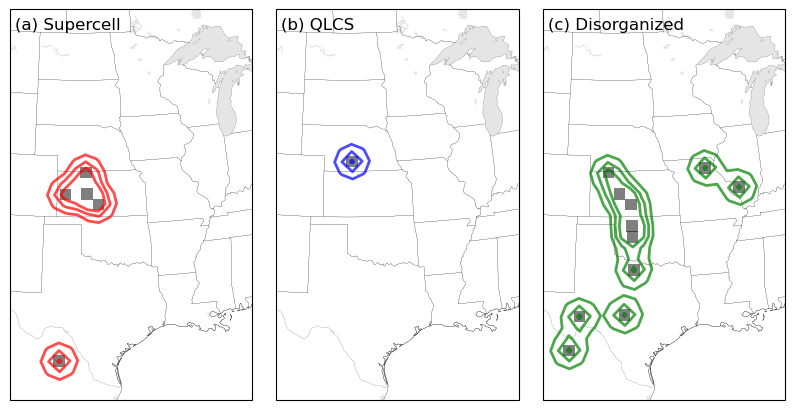

In [45]:
import matplotlib as mpl
mpl.rc_file_defaults()

fig = plt.figure(figsize=(10,6))
fig.subplots_adjust(hspace=0.15, wspace=0.1)
axes_proj = ccrs.LambertConformal(central_longitude=-100, central_latitude=37)

#thismask = ( probs['init_time'] == np.datetime64('2016-05-08'))
thismask = np.logical_and( probs['init_time'].values == np.datetime64('2016-05-08'),\
                          (probs['forecast_hour'].values == 23) )

colors = ['red', 'blue', 'green']
panels = ['(a)', '(b)', '(c)']
modes = ['Supercell', 'QLCS', 'Disorganized']
for n, mode in enumerate(modes):
    ax = fig.add_subplot(1, 3, n+1, projection=axes_proj)

    ax.set_extent([-105,-88,25,50], ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.2)
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.1)
    ax.add_feature(cfeature.LAKES.with_scale('50m'), linewidth=0.1, color='gray', alpha=0.2)
    
    c = plt.contour(probs['lon'], probs['lat'], np.amax( probs[f'CNN_1_{mode}_nprob'][thismask,:].values, axis=0), levels=[0.05,0.1,0.15,0.3],\
                lw=5, colors=colors[n], transform=ccrs.PlateCarree(), alpha=0.7, linewidths=2)
    
    maxfield = np.amax( probs[f'CNN_1_{mode}'][thismask,:].values, axis=0)
    c = plt.pcolormesh(probs['lon'], probs['lat'], np.ma.masked_less( maxfield, 1), transform=ccrs.PlateCarree(), \
                       edgecolors='None', linewidths=0, cmap=plt.get_cmap('Greys_r'), shading='nearest', alpha=0.5)
    
    ax.text(0.02,0.98, '%s %s'%(panels[n],mode), fontsize=12, transform=ax.transAxes, ha='left', va='top')
    
plt.savefig('neighborhood_mode_example.png', bbox_inches='tight', dpi=150)